## Capstone Project: Predictive Modelling for COVID-19 in Public Health

#### Data Preprocessing
1. Cleaning the Dataset

In [2]:
# Load the dataset
import pandas as pd

data = pd.read_csv("covid_19_clean_complete.csv")
data.head()



,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active,WHO Region
0,NaN,Afghanistan,33.93911,67.709953,2020-01-22,0,0,0,0,Eastern Mediterranean
1,NaN,Albania,41.15330,20.168300,2020-01-22,0,0,0,0,Europe
2,NaN,Algeria,28.03390,1.659600,2020-01-22,0,0,0,0,Africa
3,NaN,Andorra,42.50630,1.521800,2020-01-22,0,0,0,0,Europe
4,NaN,Angola,-11.20270,17.873900,2020-01-22,0,0,0,0,Africa


In [3]:
# Check for missing values
print("Missing values before cleaning:")
print(data.isnull().sum())




Missing values before cleaning:
Province/State    34404
Country/Region        0
Lat                   0
Long                  0
Date                  0
Confirmed             0
Deaths                0
Recovered             0
Active                0
WHO Region            0
dtype: int64


In [4]:
# Fill missing values (example: filling with 0 for simplicity)
data.fillna(0, inplace=True)

# Remove duplicates
data.drop_duplicates(inplace=True)

# Standardize date format
data['Date'] = pd.to_datetime(data['Date'])



In [5]:
# Check the cleaned dataset
print("\nDataset information after cleaning:")
data.info()


Dataset information after cleaning:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49068 entries, 0 to 49067
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Province/State  49068 non-null  object        
 1   Country/Region  49068 non-null  object        
 2   Lat             49068 non-null  float64       
 3   Long            49068 non-null  float64       
 4   Date            49068 non-null  datetime64[ns]
 5   Confirmed       49068 non-null  int64         
 6   Deaths          49068 non-null  int64         
 7   Recovered       49068 non-null  int64         
 8   Active          49068 non-null  int64         
 9   WHO Region      49068 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(4), object(3)
memory usage: 3.7+ MB


2. Transforming the Data

In [2]:
from sklearn.preprocessing import MinMaxScaler

# Select numerical columns for normalization
numerical_cols = ['Confirmed', 'Deaths', 'Recovered', 'Active']

# Adding Active Cases column if not present
if 'Active' not in data.columns:
    data['Active'] = data['Confirmed'] - data['Recovered'] - data['Deaths']

# Normalize numerical features
scaler = MinMaxScaler()
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

# Verify the normalized data
print("\nNormalized Data Sample:")
print(data[numerical_cols].head())



Normalized Data Sample:
   Confirmed  Deaths  Recovered    Active
0        0.0     0.0        0.0  0.000005
1        0.0     0.0        0.0  0.000005
2        0.0     0.0        0.0  0.000005
3        0.0     0.0        0.0  0.000005
4        0.0     0.0        0.0  0.000005


3. Feature Engineering

In [3]:
# Add daily growth rate (for simplicity, calculating as percentage change in Confirmed cases)
data['Daily Growth Rate (%)'] = data.groupby('Country/Region')['Confirmed'].pct_change().fillna(0) * 100

# Add mortality ratio (Deaths per Confirmed cases)
data['Mortality Rate (%)'] = (data['Deaths'] / data['Confirmed']).replace([float('inf'), -float('inf')], 0).fillna(0) * 100

# Add cases per population (Assuming a column named 'Population' exists, otherwise use a placeholder)
if 'Population' not in data.columns:
    data['Population'] = 1e7  # Placeholder: 10 million for all countries
data['Cases per Population'] = data['Confirmed'] / data['Population']

# Preview the new features
print("\nNew Features Sample:")
print(data[['Daily Growth Rate (%)', 'Mortality Rate (%)', 'Cases per Population']].head())



New Features Sample:
   Daily Growth Rate (%)  Mortality Rate (%)  Cases per Population
0                    0.0                 0.0                   0.0
1                    0.0                 0.0                   0.0
2                    0.0                 0.0                   0.0
3                    0.0                 0.0                   0.0
4                    0.0                 0.0                   0.0


#### Exploratory Data Analysis (EDA)

Step 1: Conducting EDA to Uncover Trends, Correlations, and Outliers
1. Trends in Case Counts Over Time

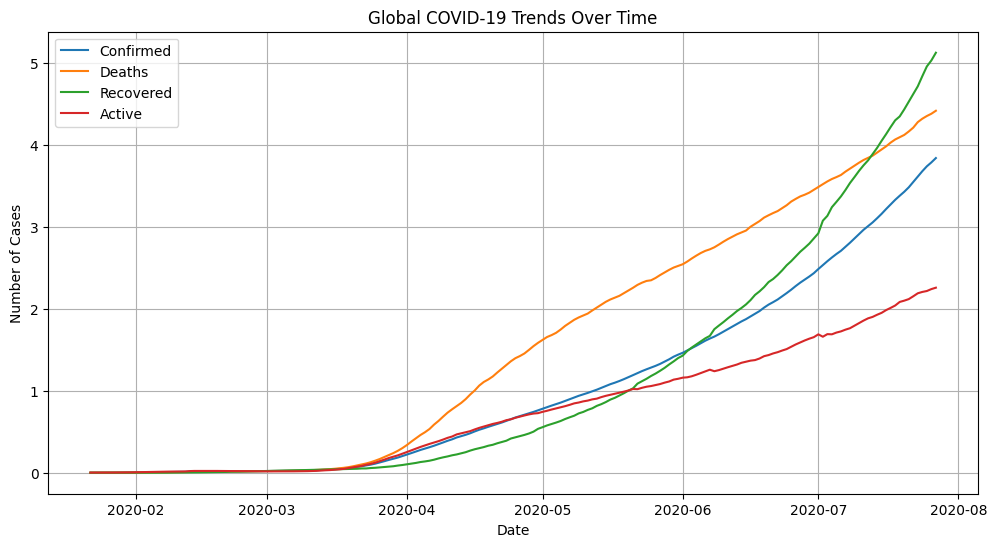

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group data by date and sum up numerical columns for global trends
global_trends = data.groupby('Date')[['Confirmed', 'Deaths', 'Recovered', 'Active']].sum().reset_index()

# Line plot for global case trends over time
plt.figure(figsize=(12, 6))
for col in ['Confirmed', 'Deaths', 'Recovered', 'Active']:
    sns.lineplot(x=global_trends['Date'], y=global_trends[col], label=col)
plt.title('Global COVID-19 Trends Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Cases')
plt.legend()
plt.grid(True)
plt.show()


2. Correlations Between Key Variables

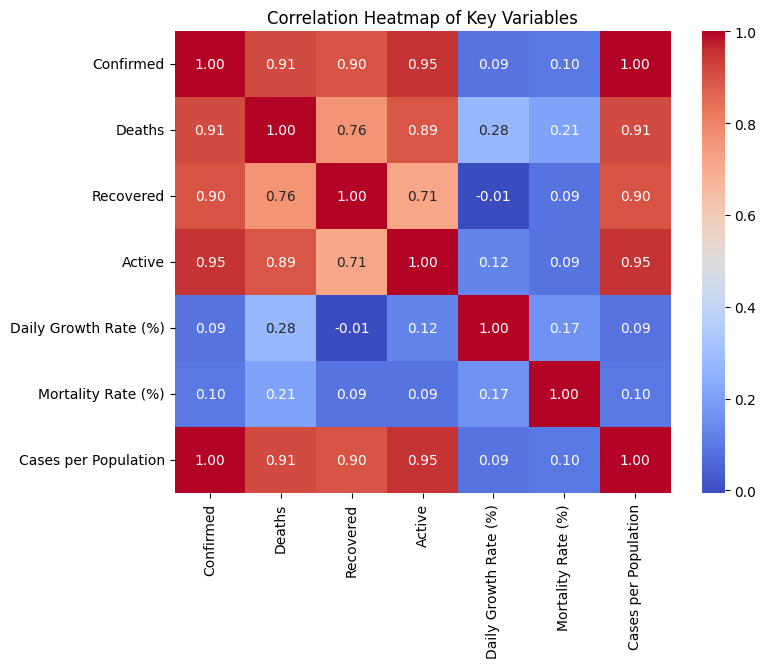

In [5]:
# Correlation heatmap
plt.figure(figsize=(8, 6))
correlation_matrix = data[['Confirmed', 'Deaths', 'Recovered', 'Active', 'Daily Growth Rate (%)', 'Mortality Rate (%)', 'Cases per Population']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Key Variables')
plt.show()


3. Identifying Outliers in Daily Growth Rates and Mortality Rates

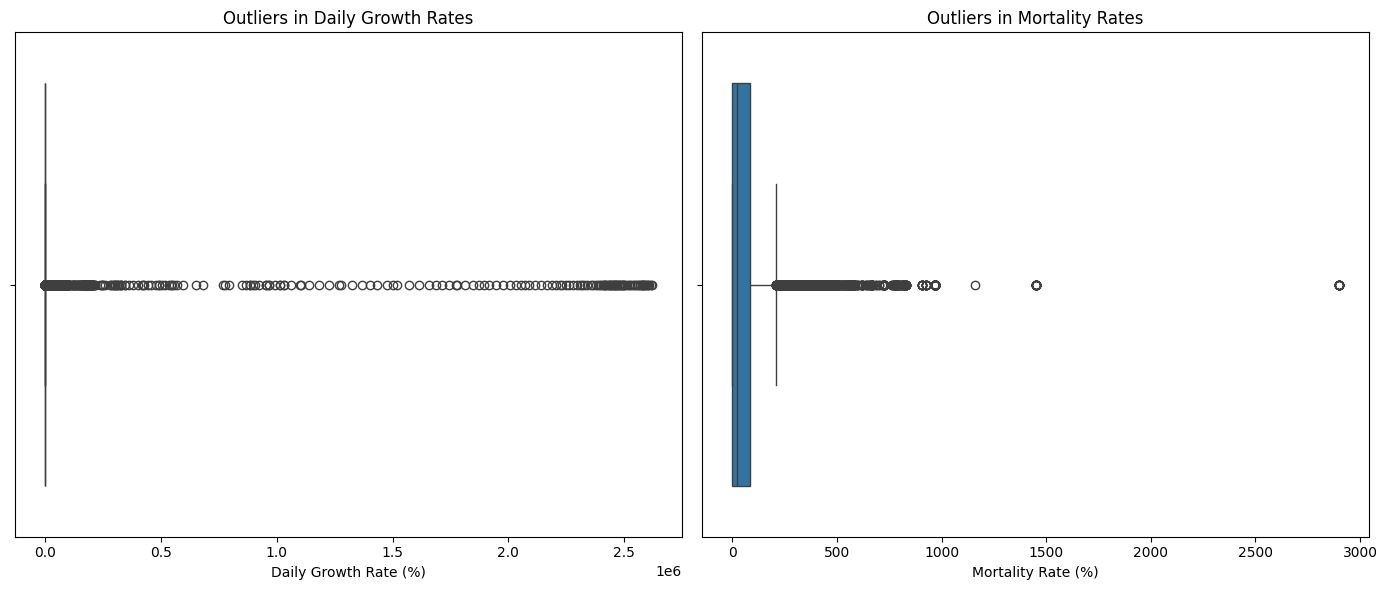

In [6]:
# Boxplots to identify outliers
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.boxplot(x=data['Daily Growth Rate (%)'])
plt.title('Outliers in Daily Growth Rates')

plt.subplot(1, 2, 2)
sns.boxplot(x=data['Mortality Rate (%)'])
plt.title('Outliers in Mortality Rates')

plt.tight_layout()
plt.show()


Step 2: Visualizations of Case and Mortality Rates
1. Mortality Rate Over Time for Top 5 Affected Countries

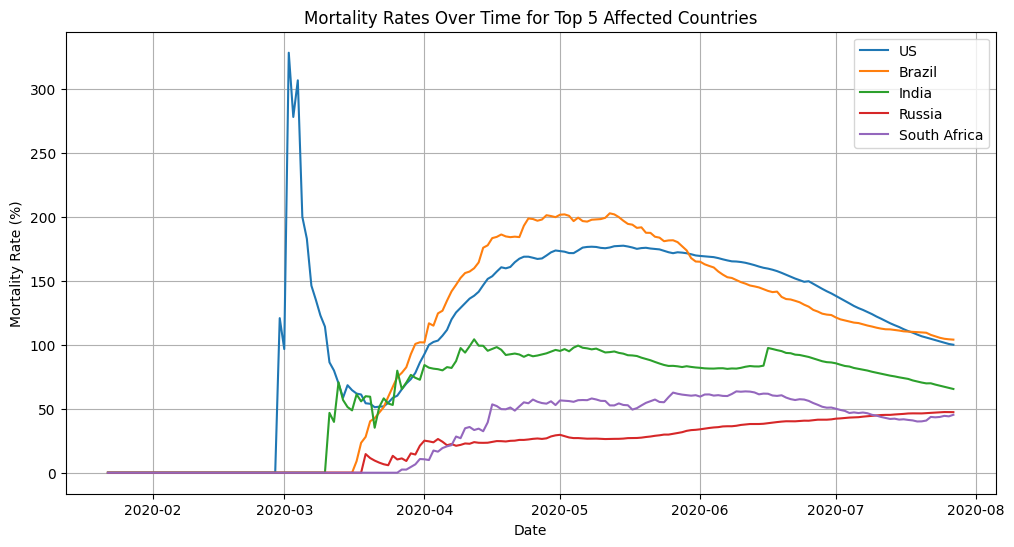

In [7]:
# Identify top 5 countries by total confirmed cases
top_countries = data.groupby('Country/Region')['Confirmed'].max().nlargest(5).index
top_countries_data = data[data['Country/Region'].isin(top_countries)]

# Line plot of mortality rate over time for top countries
plt.figure(figsize=(12, 6))
for country in top_countries:
    country_data = top_countries_data[top_countries_data['Country/Region'] == country]
    sns.lineplot(x=country_data['Date'], y=country_data['Mortality Rate (%)'], label=country)
plt.title('Mortality Rates Over Time for Top 5 Affected Countries')
plt.xlabel('Date')
plt.ylabel('Mortality Rate (%)')
plt.legend()
plt.grid(True)
plt.show()


2. Scatter Plot: Daily Growth Rate vs. Mortality Rate

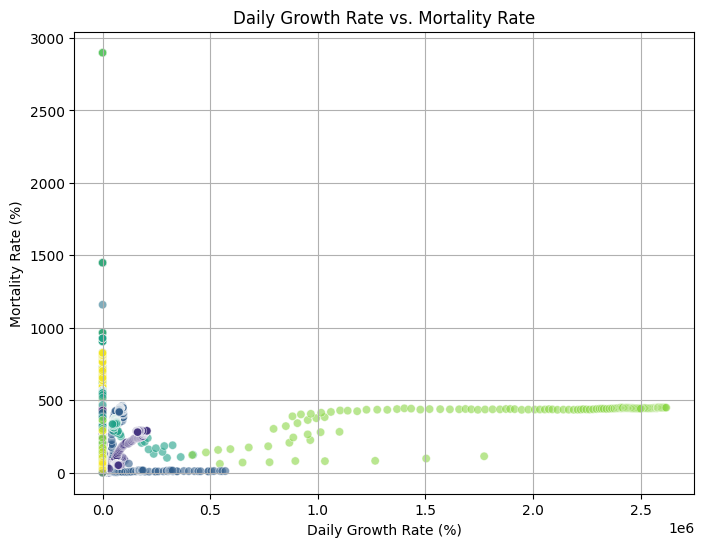

In [8]:
# Scatter plot to visualize relationship
plt.figure(figsize=(8, 6))
sns.scatterplot(x=data['Daily Growth Rate (%)'], y=data['Mortality Rate (%)'], hue=data['Country/Region'], alpha=0.6, palette='viridis', legend=False)
plt.title('Daily Growth Rate vs. Mortality Rate')
plt.xlabel('Daily Growth Rate (%)')
plt.ylabel('Mortality Rate (%)')
plt.grid(True)
plt.show()


#### Model Development

Part 1: Time-Series Modeling (Forecasting COVID-19 Trends)
- Main Objectiveof this part: To predict future confirmed cases using a time-series model.

C:\Users\charl\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


RMSE for ARIMA Time-Series Model: 0.31


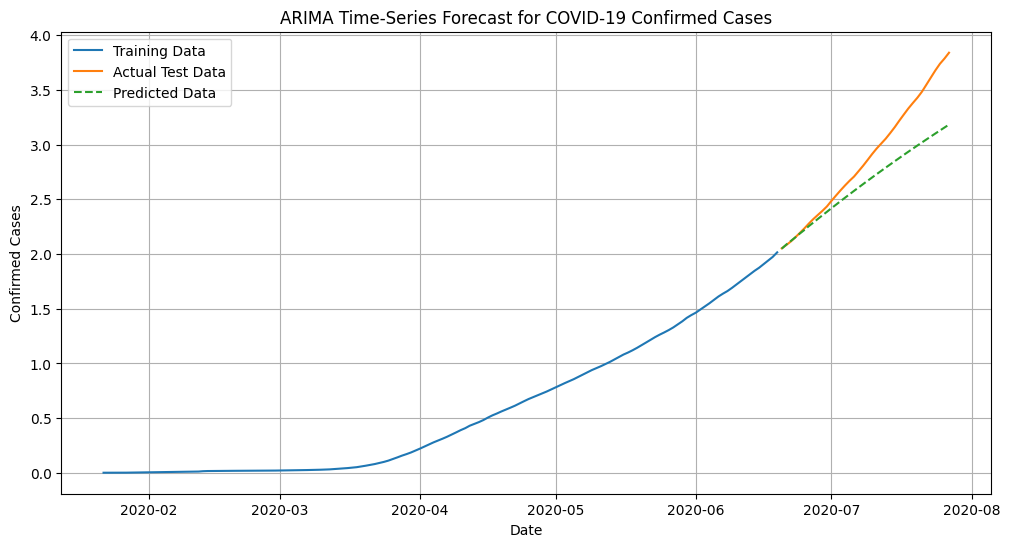

In [9]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np

# Prepare the data: Use the global confirmed cases trend for simplicity
time_series_data = global_trends[['Date', 'Confirmed']].set_index('Date').resample('D').sum()

# Split data into training and test sets
train_size = int(len(time_series_data) * 0.8)
train, test = time_series_data[:train_size], time_series_data[train_size:]

# Fit ARIMA model (order can be adjusted after testing different combinations)
model = ARIMA(train, order=(5, 1, 0))  # Order (p, d, q)
fitted_model = model.fit()

# Forecast
forecast = fitted_model.forecast(steps=len(test))

# Evaluate with RMSE
rmse = np.sqrt(mean_squared_error(test, forecast))
print(f"RMSE for ARIMA Time-Series Model: {rmse:.2f}")

# Plot predictions
plt.figure(figsize=(12, 6))
plt.plot(train, label="Training Data")
plt.plot(test, label="Actual Test Data")
plt.plot(test.index, forecast, label="Predicted Data", linestyle="--")
plt.title("ARIMA Time-Series Forecast for COVID-19 Confirmed Cases")
plt.xlabel("Date")
plt.ylabel("Confirmed Cases")
plt.legend()
plt.grid(True)
plt.show()


Part 2: Classification Modeling (Predicting High/Low Mortality)

Objective of this part:
To classify whether the mortality rate for a country on a specific day is "High" or "Low" based on other factors.


In [43]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Define the target variable (binary classification: High/Low Mortality Rate)
data['Mortality Class'] = (data['Mortality Rate (%)'] > data['Mortality Rate (%)'].median()).astype(int)

# Features and target
features = ['Cases per Population', 'Active']
X = data[features]
y = data['Mortality Class']


In [44]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [45]:
# Train a Random Forest Classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [46]:
# Predict on test data
y_pred = clf.predict(X_test)




In [47]:
# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))



Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.80      0.77      4852
           1       0.79      0.72      0.75      4962

    accuracy                           0.76      9814
   macro avg       0.76      0.76      0.76      9814
weighted avg       0.76      0.76      0.76      9814



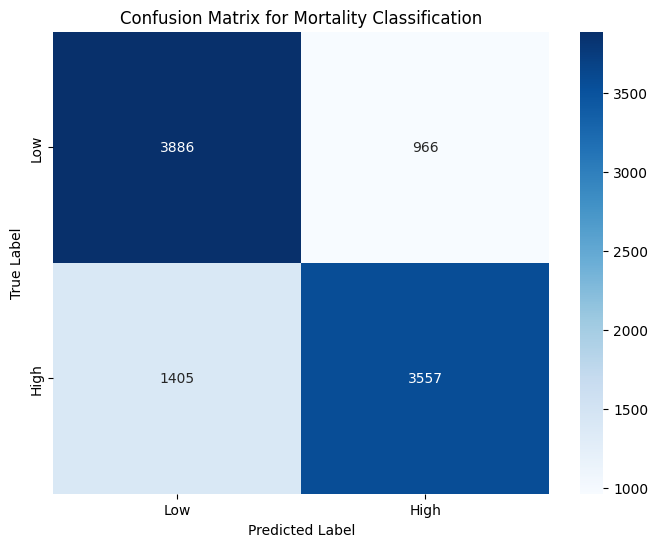

In [48]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Low", "High"], yticklabels=["Low", "High"])
plt.title("Confusion Matrix for Mortality Classification")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#### Data Visualization and Reporting
For this step, we will create compelling visualizations. The goal is to effectively communicate findings and predictions to non-technical stakeholders.

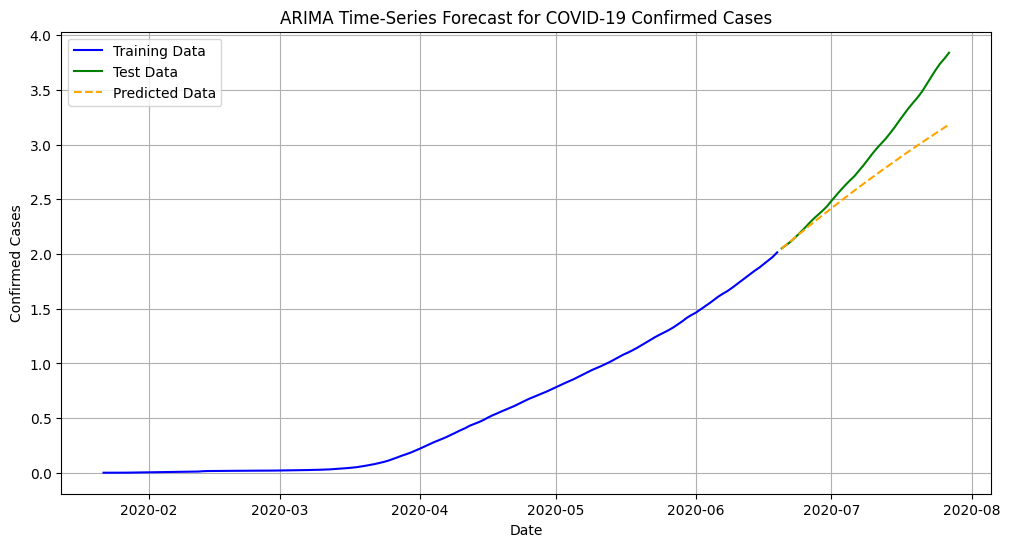

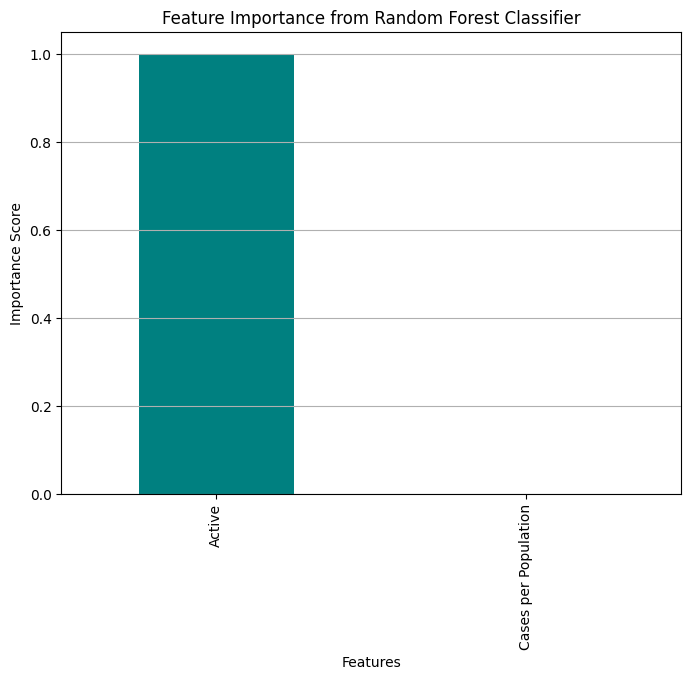

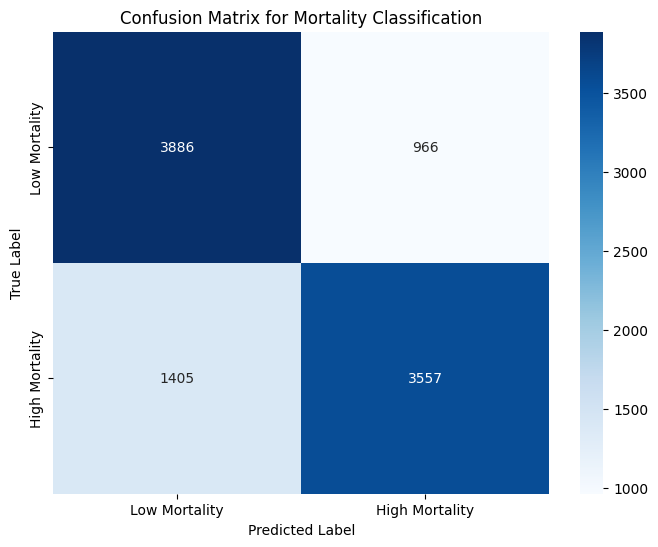

In [54]:
#import matplotlib.pyplot as plt
#import seaborn as sns

# 1. Time-Series Forecast Visualization
plt.figure(figsize=(12, 6))
plt.plot(train, label="Training Data", color='blue')
plt.plot(test, label="Test Data", color='green')
plt.plot(test.index, forecast, label="Predicted Data", color='orange', linestyle="--")
plt.title("ARIMA Time-Series Forecast for COVID-19 Confirmed Cases")
plt.xlabel("Date")
plt.ylabel("Confirmed Cases")
plt.legend()
plt.grid(True)
plt.show()

# 2. Feature Importance for Classification Model
feature_importances = pd.Series(clf.feature_importances_, index=features).sort_values(ascending=False)
plt.figure(figsize=(8, 6))
feature_importances.plot(kind='bar', color='teal')
plt.title("Feature Importance from Random Forest Classifier")
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.grid(axis='y')
plt.show()

# 3. Confusion Matrix Visualization
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Low Mortality", "High Mortality"], yticklabels=["Low Mortality", "High Mortality"])
plt.title("Confusion Matrix for Mortality Classification")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()




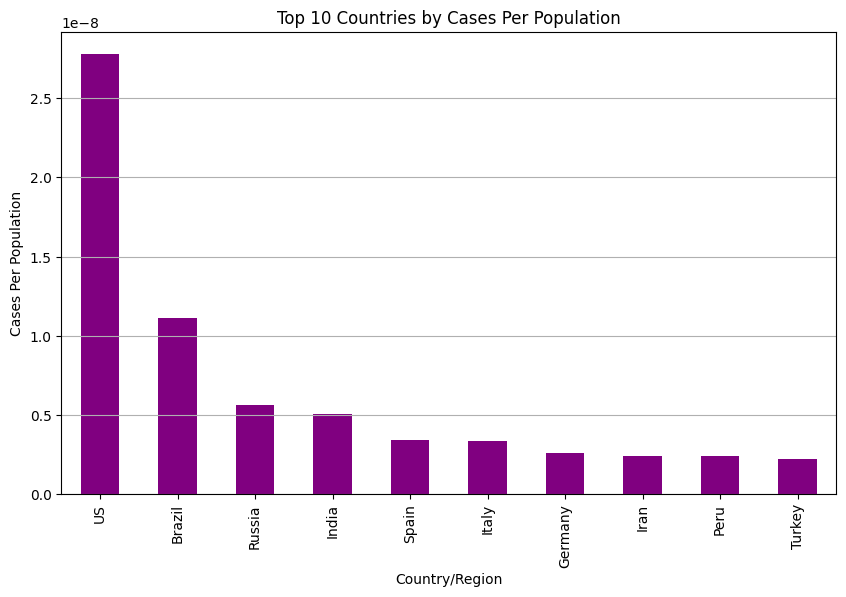

In [55]:



# 5. Cases Per Population by Country (Top 10)
top_countries = data.groupby('Country/Region')['Cases per Population'].mean().sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 6))
top_countries.plot(kind='bar', color='purple')
plt.title("Top 10 Countries by Cases Per Population")
plt.ylabel("Cases Per Population")
plt.grid(axis='y')
plt.show()


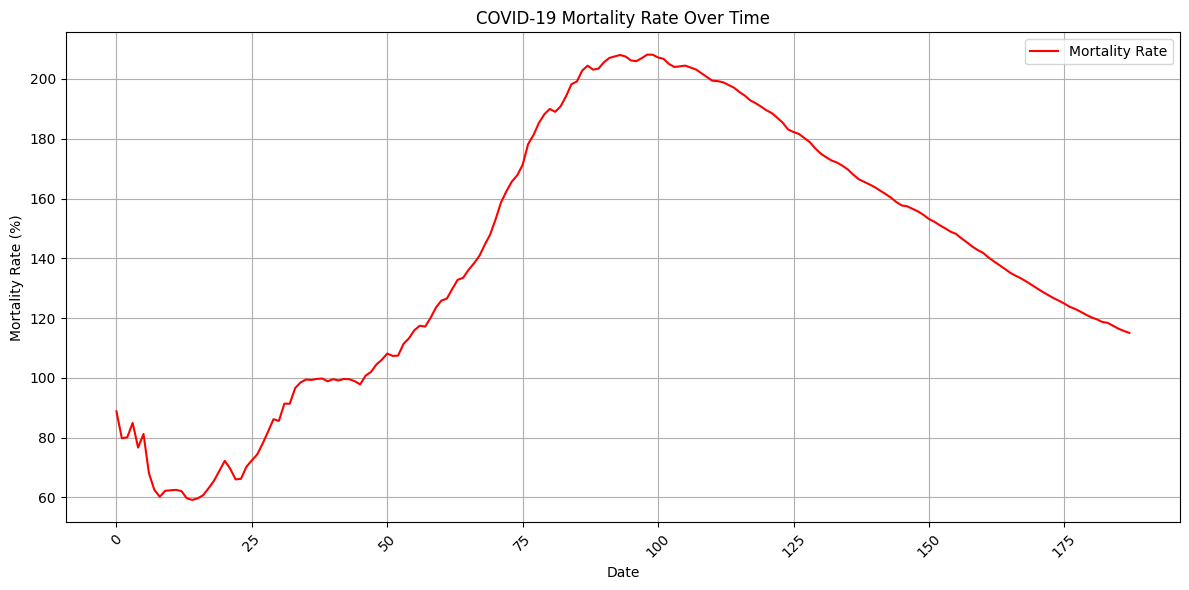

In [58]:
# Calculate Mortality Rate
global_trends['Mortality Rate (%)'] = (global_trends['Deaths'] / global_trends['Confirmed']) * 100

# Plot Mortality Rate Over Time
plt.figure(figsize=(12, 6))
sns.lineplot(data=global_trends, x=global_trends.index, y='Mortality Rate (%)', label='Mortality Rate', color='red')
plt.title("COVID-19 Mortality Rate Over Time")
plt.xlabel("Date")
plt.ylabel("Mortality Rate (%)")
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


